# Chapter 2: Fitting a geostatistical model

In the last Tutorial, we showed you how GeoGals can be used to compute a *semivariogram* -- a fast data visualisation tool that reveals the presence of spatial structure in a stochastic, spatially-correlated data field. Examination of a semivariogram reveals roughly the spatial extent of these correlations and the amount of variation that they contain. However, this is only a summary statistic. To properly estimate these quantities with their uncertainties, we need to fit a geostatistical model to the data. In this Tutorial, we show how the Python package *emcee* can be leveraged to do this.

In [30]:
import geogals as gg
from astropy.io import fits
import corner # For plotting results of model fitting
import emcee
import matplotlib.pyplot as plt
import numpy as np

Next, we load in our example data field as before, as well as its metadata:

In [2]:
data_path = '../../data/' # You may need to change this on your own computer.
Z_data    = fits.open(data_path + 'NGC1385_metals.fits')

metadata = {
    'RA':54.3680,
    'DEC':-24.5012,
    'PA': 181.3,
    'i': 44.0,
    'D': 22.7
}

For this application, we strip the metallicity data of all of its nans, and cast the resulting data structure into a dict, containing the positions, metallicities, and uncertainties in the metallicities for all measured data points.

In [3]:
Z_dict = gg.to_data_dict(Z_data[0].header, Z_data[0].data, Z_data[1].data)
len(Z_dict['Z'])

85484

This is a lot of data -- over 85,000 pixels remain! To fit a geostatistical model to all of this data would require several days on a supercomputer and use up over 200 GB of RAM. Because you might not have access to a supercomputer (and even if you do, you probably don't want to wait several days to learn how to use this package), we will take a *subsample* of 500 data points from our data. This reduces the complexity of this task by several orders of magnitude, but is still sufficient to get a good estimate of the geostatistical model parameters [(Metha et al. 2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.529..104M/abstract).

In [4]:
Z_dict = gg.get_subsample(Z_dict, n_in_subsample=500)
len(Z_dict['Z'])

500

It now behooves us to spend a little bit of time describing the *heirarchical model* that we are trying to fit. For this galaxy, we are assuming that the metallicity that we measure at each location $\vec{x}$ is the true metallicity at each location, plus some observational noise:

$$ Z_{\rm obs}(\vec{x}) = Z_{\rm true}(\vec{x}) + \epsilon(\vec{x}).$$

Two functional forms for $\epsilon$ are currently supported. By default, we assume that $\epsilon$ is independant for every observed data point (i.e. there is no spatial correlation in measurement errors). We can also model the effects of PSF smearing inducing correlations in the error between nearby points by including `'PSF'` as a key in our metadata file -- currently, only Gaussian PSFs are supported. For this application, we assume independant errors at all locations -- the size of the uncertainties is given by our supplied `e_Z` field.

We further split the true metallicity of our galaxy into two components: a spatially varying *mean metallicity* $\mu(\vec{x})$, and a stochastic component with zero mean $\eta(\vec{x})$:

$$ Z_{\rm true}(\vec{x}) = \mu(\vec{x})+ \eta(\vec{x}).$$

We model the mean metallicity of a galaxy at each location as depending only on its radius in a linear way:

$$ \mu(\vec{x}) = Z_c + \beta \cdot r.$$

Here, $\beta$ is referred to as the *metallicity gradient*, while $Z_c$ denotes the *central metallicity*. 

While $\eta(\vec{x})$ has zero mean, it is not zero everywhere. The covariance function $C(r)$ is defined to be $C(r) = \text{Cov} (\eta(\vec{x} + \vec{r}), \eta(\vec{x}))$. This function encodes all the information about the amplitude of the small-scale features, as well as their correlation. In this release, the only supported covariance function is the exponential kernel (please let us know if you want support adding other covariance functions):

$$ C(r) = A \exp( - \frac{r}{\phi}).$$

Here, $A = \sigma^2$ is the *total variance* in our data field (from spatially correlated sources), and $\phi$ is the characteristic length scale of correlations within our data.

In total, this model has four parameters. We put these together into our vector of parameters, $\theta = [\log(A), \phi, Z_c, \beta]$ (we prefer to fit $\log(A)$ over $A$ for better numerical stability). **It is our goal to estimate the values of each of these parameters, as well as their uncertainties**, for our galaxy of interest.

To do this, we must first come up with an initial guess of what we expect these parameters to be, as well as our uncertainties about them. We can do this blindly:

In [16]:
# Our initial guess
init_theta = [-1, 250, 8.8, -0.01] # (based on reasonable values)
# And our uncertainties about it
init_unc_theta = [0.4, 50, 0.5, 0.05]

Or we could also run a linear fit to get initial estimates for the large-scale parameters. This is fast to do and can often give us a starting point that is closer to the correct answer.

In [17]:
linear_params, param_cov_matrix = gg.fit_radial_linear_trend(Z_dict, metadata, return_covariances= True)
linear_params

array([ 8.81578267, -0.01126776])

The last thing that we need for a model fit is a backend -- a place to store the results of our Monte Carlo fitting procedure.

In [18]:
backend_f = data_path + 'NGC1385_MC_results.hdf5'

Now we are ready to run the emcee sampler and find the best fitting parameters for this galaxy! In this example, we keep the number of samples and walkers moderately small to make sure this code can finish in under a minute -- we will see the consequences of this choice later.

In [26]:
f_acc = gg.fit_exp_cov_model(data_dict=Z_dict, meta=metadata, n_samples=150, n_walkers=30, backend_f=backend_f, init_theta=init_theta, init_unc_theta=init_unc_theta)
print("Mean acceptance fraction of the chains: {0:.3f}".format(f_acc))

100%|██████████████████████████████████████████████████████████████████████████| 150/150 [00:51<00:00,  2.89it/s]

Mean acceptance fraction of the chains: 0.461


The results of our model fitting procedure are stored in the backend file. We can access these to plot the chains and the sampled posterior of our parameter distribution:

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/2d/15b5vkmj307739k5jgkn0ynr0000gq/T/ipykernel_80192/412061883.py:4: SyntaxWarning: invalid escape sequence '\l'
  labels = labels = ['$\log(\sigma^2)$', '$\phi$ (pc)', '$Z_{c}$', '$\\nabla Z$ (kpc$^{-1}$)' ]
/var/folders/2d/15b5vkmj307739k5jgkn0ynr0000gq/T/ipykernel_80192/412061883.py:4: SyntaxWarning: invalid escape sequence '\p'
  labels = labels = ['$\log(\sigma^2)$', '$\phi$ (pc)', '$Z_{c}$', '$\\nabla Z$ (kpc$^{-1}$)' ]


Text(0.5, 0, 'step number')

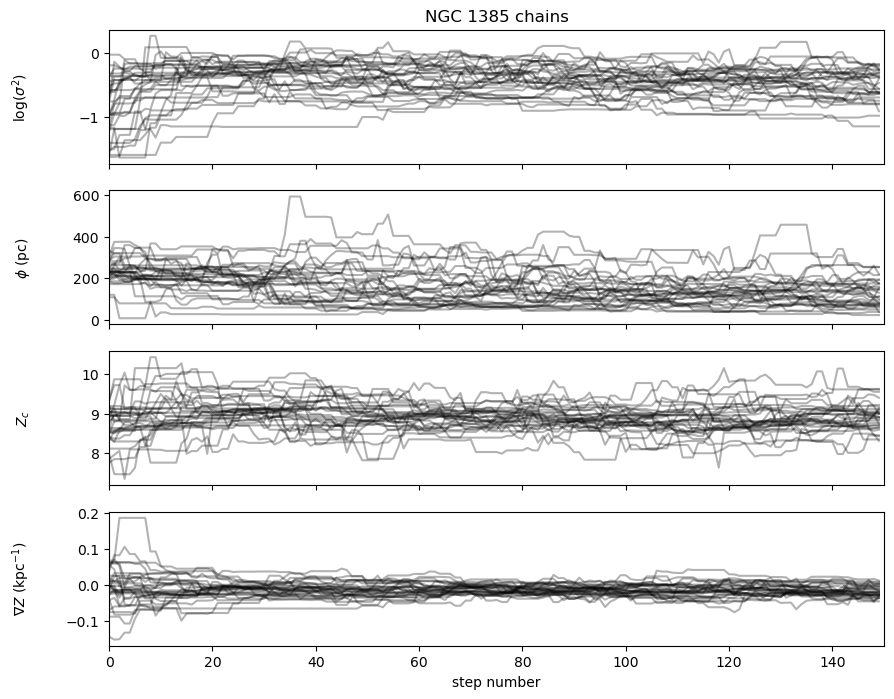

In [27]:
result = emcee.backends.HDFBackend(backend_f, read_only=True)
chains = result.get_chain()
# Make a figure with all 4 chains and save it
labels = labels = ['$\log(\sigma^2)$', '$\phi$ (pc)', '$Z_{c}$', '$\\nabla Z$ (kpc$^{-1}$)' ]
chain_fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
axes[0].set_title("NGC 1385 chains")
for i in range(4):
    ax = axes[i]
    ax.plot(chains[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

From these plots, we see that the first ~25 steps of these Monte Carlo chains ought to be discarded to burn-in. After removing these samples, we can create corner plots for our final parameter distribution:

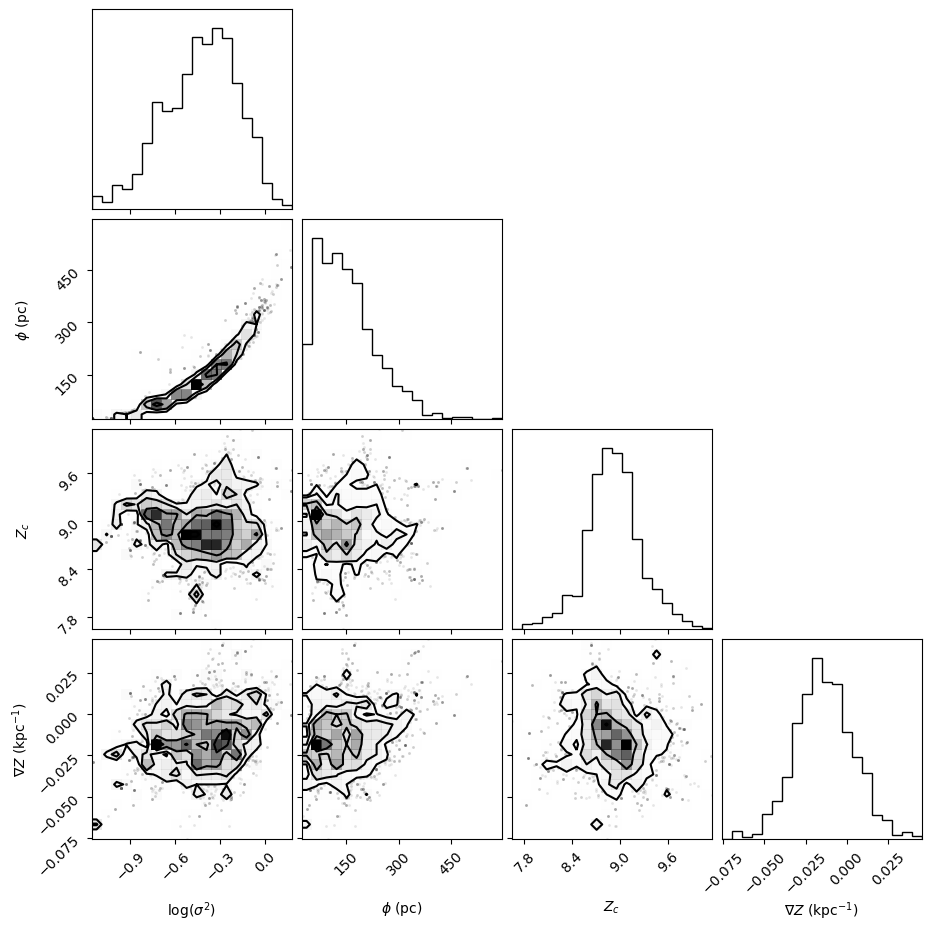

In [28]:
burn_in = 25 # from plot above
flat_samples = result.get_chain(discard=burn_in, flat=True)
corner_fig = corner.corner(flat_samples, labels=labels)

Clearly, these results are a bit patchy -- a larger number of samples will give us more natural-looking distributions. Even still, we can use this collection of samples to find the median a posteriori values of our model parameters, as well as their confidence intervals:

In [34]:
medians = np.median(flat_samples, axis=0)
percentile_16 = np.percentile(flat_samples, 16, axis=0)
percentile_84 = np.percentile(flat_samples, 84, axis=0)

Once we have a best estimate for the parameters of our geostatistical model, we can use them to predict the values of our random field at locations where there are no measurements via *kriging*. We cover how this can be done in the next Tutorial.